In [1]:
import numpy as np
import sunpy
import sunpy.map
from sunpy.coordinates import get_horizons_coord, propagate_with_solar_surface
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import patheffects as path_effects
from matplotlib.ticker import LogFormatterSciNotation
from scipy.interpolate import LinearNDInterpolator
import astropy
import astropy.units as u
from astropy.io import fits
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.visualization.wcsaxes import add_scalebar
from glob import glob
import os
from watroo import wow
from sunraster.instr.spice import read_spice_l2_fits
import sunkit_image.coalignment as coalignment
from fancy_colorbar import plot_colorbar, wcs_scalebar

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1,
                 'xtick.major.width': 1, 'xtick.major.size': 3,
                 'ytick.major.width': 1, 'ytick.major.size': 3,
                 'xtick.minor.width': 1, 'xtick.minor.size': 1.5,
                 'ytick.minor.width': 1, 'ytick.minor.size': 1.5,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}' r'\usepackage{fixltx2e}'}
rcParams.update(ms_style_dict)

In [3]:
def interpolate_spice_map_to_target_wcs(spice_map, spice_coalign_wcs, spice_time,
                                        hri_map,
                                        spice_solarx_shift, 
                                        spice_solary_shift):
    spice_nx = spice_nt = spice_map.data.shape[1]
    spice_map = spice_map.submap([0, 120]*u.pix, top_right=[spice_nx, 699]*u.pix)
    spice_ny = spice_map.data.shape[0]
    spice_pix_t, spice_pix_y, spice_pix_x = np.indices((1,*spice_map.data.shape))
    spice_world_coords = spice_coalign_wcs.pixel_to_world(spice_pix_x, spice_pix_y, spice_pix_t)[0][0,:,:]

    solar_orbiter_loc = np.flip(get_horizons_coord('solar orbiter',
                                                {'start':spice_time[-1],
                                                'stop':spice_time[0],
                                                'step':f'{spice_nt}'}))
    
    spice_pix_y_in_target_wcs = np.zeros((spice_ny, spice_nx))
    spice_pix_x_in_target_wcs = np.zeros((spice_ny, spice_nx))

    target_wcs = hri_map.wcs

    for ii in range(spice_nt):
        spice_world_coord_t = SkyCoord(spice_world_coords[:,ii].Tx.to(u.arcsec) + spice_solarx_shift[ii]*u.arcsec, 
                                  spice_world_coords[:,ii].Ty.to(u.arcsec) + spice_solary_shift[ii]*u.arcsec,
                                  frame='helioprojective',obstime=spice_time[ii], 
                                  observer=solar_orbiter_loc[ii], 
                                  rsun=hri_map.meta['rsun_ref']*u.m,)
        
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_pix_x_in_target_wcs[:,ii], spice_pix_y_in_target_wcs[:,ii] = target_wcs.world_to_pixel(spice_world_coord_t)

    hri_map_pix_y, hri_map_pix_x = np.indices(hri_map.data.shape)

    spice_map_interpolator = LinearNDInterpolator((spice_pix_x_in_target_wcs.flatten(), spice_pix_y_in_target_wcs.flatten()), spice_map.data.flatten())

    spice_map_interpolated = spice_map_interpolator(hri_map_pix_x, hri_map_pix_y)
    spice_map_interpolated = sunpy.map.Map(spice_map_interpolated, target_wcs)
    spice_map_interpolated.meta['rsun_ref'] = hri_map.meta['rsun_ref']
    return spice_map_interpolated

In [4]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [5]:
def get_saffron_map(saffron_file_dir, spice_cube, spice_time, hri_map_buffer, 
                    spice_solarx_shift, spice_solary_shift):
    try:
        spice_coalign_wcs = spice_cube['Ne VIII 770 - Peak'].wcs.dropaxis(2)[:,120:700,:]
    except:
        spice_coalign_wcs = spice_cube['Ne VIII 770 / Mg VIII 772 (Merged)'].wcs.dropaxis(2)[:,120:700,:]

    saffron_NeVIII_file_path = glob(os.path.join(saffron_file_dir, '*770.42-ne_8*.fits'))[0]
    # saffron_NIV_file_path = glob(os.path.join(saffron_file_dir, '*765.15-n_4*.fits'))[0]
    saffron_NIV_file_path = glob(os.path.join(saffron_file_dir, '*770.42-ne_8*.fits'))[0]

    saffron_map = sunpy.map.Map(saffron_NIV_file_path)
    saffron_int_map = saffron_map[0]
    saffron_wid_map = saffron_map[2]
    saffron_int_map = sunpy.map.Map(saffron_int_map.data*saffron_wid_map.data*np.sqrt(np.pi), saffron_int_map.meta)
    saffron_int_map = interpolate_spice_map_to_target_wcs(saffron_int_map, spice_coalign_wcs, spice_time, hri_map_buffer, 
                                                         spice_solarx_shift, spice_solary_shift)
    saffron_int_size = saffron_int_map.data.shape[::-1]
    saffron_int_map_crop = saffron_int_map.submap([20,20]*u.pix, top_right=[saffron_int_size[0]-20, saffron_int_size[1]-20]*u.pix)

    spice_additional_Txshift, spice_additional_Tyshift = coalign_shift(hri_map_buffer, saffron_int_map_crop)
    saffron_int_map = saffron_int_map.shift_reference_coord(spice_additional_Txshift, spice_additional_Tyshift)
    
    saffron_map = sunpy.map.Map(saffron_NeVIII_file_path)
    saffron_vel_map = saffron_map[1]

    saffron_velmap_data = saffron_vel_map.data.copy()
    saffron_velmap_data = (saffron_velmap_data/np.nanmedian(saffron_velmap_data) - 1)*const.c.to_value(u.km/u.s)
    saffron_velmap_median = np.nanmedian(saffron_velmap_data[120:699,:], axis=0)
    saffron_velmap_median_fit_param = np.polyfit(np.arange(saffron_velmap_median.shape[0]), saffron_velmap_median, 1)
    saffron_velmap_data = saffron_velmap_data - np.polyval(saffron_velmap_median_fit_param, np.arange(saffron_velmap_median.shape[0]))[np.newaxis,:]
    saffron_vel_map = sunpy.map.Map(saffron_velmap_data, saffron_map[1].meta)

    saffron_vel_map = interpolate_spice_map_to_target_wcs(saffron_vel_map, spice_coalign_wcs, spice_time, hri_map_buffer,
                                                            spice_solarx_shift, spice_solary_shift)
    
    saffron_vel_map = saffron_vel_map.shift_reference_coord(spice_additional_Txshift, spice_additional_Tyshift)
    
    return saffron_int_map, saffron_vel_map
    

In [6]:
def get_hri_hrt_spice(hri_file_path, hrt_file_path, spice_file_path,
                      spice_saffron_file_dir,bottom_left_coord, top_right_coord,
                      hri_Txshift=0*u.arcsec, hri_Tyshift=0*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec, 
                      rsun_ref = 696000000):
    hri_map = sunpy.map.Map(hri_file_path)
    hri_map.meta['rsun_ref'] = rsun_ref
    hri_map = hri_map.shift_reference_coord(hri_Txshift, hri_Tyshift)
    bottom_left_coord = SkyCoord(bottom_left_coord[0], bottom_left_coord[1], frame=hri_map.coordinate_frame)
    top_right_coord = SkyCoord(top_right_coord[0], top_right_coord[1], frame=hri_map.coordinate_frame)

    bottom_left_coord_buffer = SkyCoord(bottom_left_coord.Tx - 50*u.arcsec, bottom_left_coord.Ty - 50*u.arcsec, frame=hri_map.coordinate_frame)
    top_right_coord_buffer = SkyCoord(top_right_coord.Tx + 50*u.arcsec, top_right_coord.Ty + 50*u.arcsec, frame=hri_map.coordinate_frame)

    hri_map_buffer = hri_map.submap(bottom_left_coord_buffer, top_right=top_right_coord_buffer)
    hri_map = hri_map.submap(bottom_left_coord, top_right=top_right_coord)
    
    hri_map = sunpy.map.Map(wow(hri_map.data, bilateral=1, denoise_coefficients=[5,3])[0],
                            hri_map.meta)


    hrt_map = sunpy.map.Map(hrt_file_path)
    hrt_map = hrt_map.submap(bottom_left_coord, top_right=top_right_coord)
    hrt_map.meta['rsun_ref'] = rsun_ref
    
    spice_cube = read_spice_l2_fits(spice_file_path)
    with fits.open(spice_file_path) as hdul:
        spice_solarx_shift = hdul[-2].data.copy() + fsi_Txshift.to_value(u.arcsec)
        spice_solary_shift = hdul[-1].data.copy() + fsi_Tyshift.to_value(u.arcsec)

    try:
        spice_time = spice_cube['Ne VIII 770 - Peak'].time[0]
    except:
        spice_time = spice_cube['Ne VIII 770 / Mg VIII 772 (Merged)'].time[0]

    saffron_int_map, saffron_vel_map = get_saffron_map(spice_saffron_file_dir, spice_cube, spice_time, hri_map_buffer,
                                                         spice_solarx_shift, spice_solary_shift)
    
    saffron_int_map = saffron_int_map.reproject_to(hri_map.wcs)
    saffron_vel_map = saffron_vel_map.reproject_to(hri_map.wcs)
    
    return hri_map, hrt_map, saffron_int_map, saffron_vel_map

In [7]:
(hri_map_1020, hrt_map_1020,
saffron_int_map_1020, saffron_vel_map_1020) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221020/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                    "../../src/coalign_map/20221020/phi_los_map_shifted_to_aia.fits",
                    "../../src/SPICE/20221020/solo_L2_spice-n-ras_20221020T231536_V06_150995364-000_coalign.fits",
                    "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221020T231536_V06_150995364-000/con-06/",
                    bottom_left_coord=[-930,610]*u.arcsec, top_right_coord=[-830,710]*u.arcsec,
                    hri_Txshift=(9.41462 - 20.8515)*u.arcsec, hri_Tyshift=(7.05089-8.29747)*u.arcsec,
                    fsi_Txshift=-14.2*u.arcsec, fsi_Tyshift=-4.5*u.arcsec)

Set MJD-OBS to 59872.969168 from DATE-OBS.
Set MJD-BEG to 59872.969168 from DATE-BEG.
Set MJD-AVG to 59873.047270 from DATE-AVG.
Set MJD-END to 59873.125369 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [8]:
(hri_map_1022, hrt_map_1022,
saffron_int_map_1022, saffron_vel_map_1022) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221022/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                      "../../src/coalign_map/20221022/phi_los_map_shifted_hrifov.fits",
                      "../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000_coalign.fits",
                      "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221022T205536_V06_150995382-000/con-06/",
                      bottom_left_coord=[-40,380]*u.arcsec, top_right_coord=[60,480]*u.arcsec,
                      hri_Txshift=(6.6003 - 0)*u.arcsec, hri_Tyshift=(8.15779-0)*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec)

Set MJD-OBS to 59874.871951 from DATE-OBS.
Set MJD-BEG to 59874.871951 from DATE-BEG.
Set MJD-AVG to 59874.950052 from DATE-AVG.
Set MJD-END to 59875.028152 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [9]:
(hri_map_1023, hrt_map_1023,
saffron_int_map_1023, saffron_vel_map_1023) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221023/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                      "../../src/coalign_map/20221023/phi_los_map_shifted.fits",
                      "../../src/SPICE/20221023/solo_L2_spice-n-ras_20221023T195035_V03_150995388-000_coalign.fits",
                      "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221023T195035_V03_150995388-000/con-06/",
                      bottom_left_coord=[370,340]*u.arcsec, top_right_coord=[480,450]*u.arcsec,
                      hri_Txshift=(4.26535 + 0.334497)*u.arcsec, hri_Tyshift=(7.96536 - 3.79503)*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec)

Set MJD-OBS to 59875.826803 from DATE-OBS.
Set MJD-BEG to 59875.826803 from DATE-BEG.
Set MJD-AVG to 59875.893748 from DATE-AVG.
Set MJD-END to 59875.960690 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [15]:
(hri_map_1024, hrt_map_1024,
saffron_int_map_1024, saffron_vel_map_1024) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221024/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                      "../../src/coalign_map/20221024/phi_los_map_shifted.fits",
                      "../../src/SPICE/20221024/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000_coalign.fits",
                      "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221024T231535_V07_150995398-000/con-06/",
                      bottom_left_coord=[660,330]*u.arcsec, top_right_coord=[860,530]*u.arcsec,
                      hri_Txshift=(1.66986 + 2.49223)*u.arcsec, hri_Tyshift=(7.60204 - 2.76366 )*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec)

Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [11]:
(hri_map_1025, hrt_map_1025,
saffron_int_map_1025, saffron_vel_map_1025) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221025/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                      "../../src/coalign_map/20221025/phi_los_map_shifted.fits",
                      "../../src/SPICE/20221025/solo_L2_spice-n-ras_20221025T195035_V03_150995402-000_coalign.fits",
                      "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221025T195035_V03_150995402-000/con-06/",
                      bottom_left_coord=[1030,320]*u.arcsec, top_right_coord=[1230,520]*u.arcsec,
                      hri_Txshift=(1.09602 - 0.419833)*u.arcsec, hri_Tyshift=(7.37633-0.200863)*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec)

Set MJD-OBS to 59877.826805 from DATE-OBS.
Set MJD-BEG to 59877.826805 from DATE-BEG.
Set MJD-AVG to 59877.893750 from DATE-AVG.
Set MJD-END to 59877.960692 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [12]:
(hri_map_1026, hrt_map_1026,
saffron_int_map_1026, saffron_vel_map_1026) = \
    get_hri_hrt_spice("../../src/EUI/HRI/euv174/20221026/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits",
                      "../../src/coalign_map/20221026/phi_los_map_shifted.fits",
                      "../../src/SPICE/20221026/solo_L2_spice-n-ras_20221026T070202_V03_150995415-000_coalign.fits",
                      "../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221026T070202_V03_150995415-000/con-06/",
                      bottom_left_coord=[1320,400]*u.arcsec, top_right_coord=[1420,500]*u.arcsec,
                      hri_Txshift=(-0.0235313-6.3736)*u.arcsec, hri_Tyshift=(7.82867-0.685765)*u.arcsec,
                      fsi_Txshift=0*u.arcsec, fsi_Tyshift=0*u.arcsec)

Set MJD-OBS to 59878.293082 from DATE-OBS.
Set MJD-BEG to 59878.293082 from DATE-BEG.
Set MJD-AVG to 59878.360027 from DATE-AVG.
Set MJD-END to 59878.426968 from DATE-END'. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


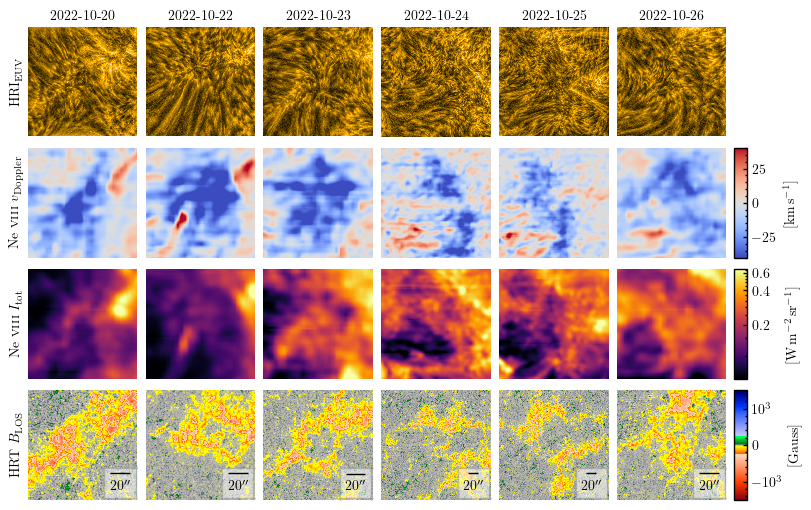

In [16]:
fig = plt.figure(figsize=(8,5), layout='constrained')
ax11 = fig.add_subplot(4,6,1, projection=hri_map_1020)
ax21 = fig.add_subplot(4,6,1+1*6, projection=saffron_vel_map_1020)
ax31 = fig.add_subplot(4,6,1+2*6, projection=saffron_int_map_1020)
ax41 = fig.add_subplot(4,6,1+3*6, projection=hrt_map_1020)

ax12 = fig.add_subplot(4,6,2, projection=hri_map_1022)
ax22 = fig.add_subplot(4,6,2+1*6, projection=saffron_vel_map_1022)
ax32 = fig.add_subplot(4,6,2+2*6, projection=saffron_int_map_1022)
ax42 = fig.add_subplot(4,6,2+3*6, projection=hrt_map_1022)

ax13 = fig.add_subplot(4,6,3, projection=hri_map_1023)
ax23 = fig.add_subplot(4,6,3+1*6, projection=saffron_vel_map_1023)
ax33 = fig.add_subplot(4,6,3+2*6, projection=saffron_int_map_1023)
ax43 = fig.add_subplot(4,6,3+3*6, projection=hrt_map_1023)

ax14 = fig.add_subplot(4,6,4, projection=hri_map_1024)
ax24 = fig.add_subplot(4,6,4+1*6, projection=saffron_vel_map_1024)
ax34 = fig.add_subplot(4,6,4+2*6, projection=saffron_int_map_1024)
ax44 = fig.add_subplot(4,6,4+3*6, projection=hrt_map_1024)

ax15 = fig.add_subplot(4,6,5, projection=hri_map_1025)
ax25 = fig.add_subplot(4,6,5+1*6, projection=saffron_vel_map_1025)
ax35 = fig.add_subplot(4,6,5+2*6, projection=saffron_int_map_1025)
ax45 = fig.add_subplot(4,6,5+3*6, projection=hrt_map_1025)

ax16 = fig.add_subplot(4,6,6, projection=hri_map_1026)
ax26 = fig.add_subplot(4,6,6+1*6, projection=saffron_vel_map_1026)
ax36 = fig.add_subplot(4,6,6+2*6, projection=saffron_int_map_1026)
ax46 = fig.add_subplot(4,6,6+3*6, projection=hrt_map_1026)


hri_map_1020.plot(axes=ax11, norm=ImageNormalize(), title=None)
saffron_vel_map_1020.plot(axes=ax21, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                          cmap='coolwarm')
saffron_int_map_1020.plot(axes=ax31, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1020.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1020.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
hrt_map_1020.plot(axes=ax41, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

hri_map_1022.plot(axes=ax12, norm=ImageNormalize(), title=None)
saffron_vel_map_1022.plot(axes=ax22, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                            cmap='coolwarm')
saffron_int_map_1022.plot(axes=ax32, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1022.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1022.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
hrt_map_1022.plot(axes=ax42, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

hri_map_1023.plot(axes=ax13, norm=ImageNormalize(), title=None)
saffron_vel_map_1023.plot(axes=ax23, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                            cmap='coolwarm')
saffron_int_map_1023.plot(axes=ax33, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1023.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1023.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
hrt_map_1023.plot(axes=ax43, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

hri_map_1024.plot(axes=ax14, norm=ImageNormalize(), title=None)
saffron_vel_map_1024.plot(axes=ax24, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                            cmap='coolwarm')
saffron_int_map_1024.plot(axes=ax34, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1024.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1024.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
hrt_map_1024.plot(axes=ax44, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

hri_map_1025.plot(axes=ax15, norm=ImageNormalize(), title=None)
saffron_vel_map_1025.plot(axes=ax25, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                            cmap='coolwarm')
saffron_int_map_1025.plot(axes=ax35, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1025.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1025.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
hrt_map_1025.plot(axes=ax45, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

hri_map_1026.plot(axes=ax16, norm=ImageNormalize(), title=None)
im26 = saffron_vel_map_1026.plot(axes=ax26, norm=ImageNormalize(vmin=-40,vmax=40), title=None,
                            cmap='coolwarm')
im36 = saffron_int_map_1026.plot(axes=ax36, norm=ImageNormalize(vmin=np.nanpercentile(saffron_int_map_1026.data,0.5),
                                                        vmax=np.nanpercentile(saffron_int_map_1026.data,99.5),
                                                        stretch=AsinhStretch(0.1)), title=None, cmap='inferno')
im46 = hrt_map_1026.plot(axes=ax46, norm=ImageNormalize(vmin=-1500,vmax=1500), title=None, cmap='hmimag')

clb26, clb_ax26 = plot_colorbar(im26, ax26,
              bbox_to_anchor=(1.07, 0, 0.12, 1),)
clb26.set_label(r'$\mathrm{[km\,s^{-1}]}$', labelpad=5)

clb36, clb_ax36 = plot_colorbar(im36, ax36, 
                bbox_to_anchor=(1.07, 0, 0.12, 1),)
clb36.set_label(r'$\mathrm{[W\,m^{-2}\,sr^{-1}]}$', labelpad=11)

clb46, clb_ax46 = plot_colorbar(im46, ax46,
                bbox_to_anchor=(1.07, 0, 0.12, 1), )
clb46.set_label(r'$\mathrm{[Gauss]}$', labelpad=4)

clb_ax46.yaxis.set_major_formatter(LogFormatterSciNotation())




for ax_ in fig.get_axes():
    ax_.axis('off')
    ax_.coords[0].axislabels.set_visible(False)
    ax_.coords[1].axislabels.set_visible(False)
    ax_.coords[0].set_ticklabel_visible(False)
    ax_.coords[1].set_ticklabel_visible(False)
    ax_.coords[0].set_ticks_visible(False)

for ax_ in (ax41,ax42,ax43,ax44,ax45,ax46):
    wcs_scalebar(ax_, length=20*u.arcsec, color='black', label=r'$20^{\prime\prime}$', corner='bottom right', borderpad=0.02,
                 frame=True,bbox_props=dict(boxstyle='round,pad=-0.1',facecolor='white', edgecolor='#91989F', alpha=0.5))
    
ax11.text(-0.1, 0.5, r'HRI\textsubscript{EUV}', transform=ax11.transAxes, rotation=90, va='center', ha='center')
ax21.text(-0.1, 0.5, r'Ne \textsc{viii} $v_{\rm Doppler}$', transform=ax21.transAxes, rotation=90, va='center', ha='center')
ax31.text(-0.1, 0.5, r'Ne \textsc{viii} $I_{\rm tot}$', transform=ax31.transAxes, rotation=90, va='center', ha='center')
ax41.text(-0.1, 0.5, r'HRT $B_{\rm LOS}$', transform=ax41.transAxes, rotation=90, va='center', ha='center')

ax11.text(0.5, 1.1, r'2022-10-20', transform=ax11.transAxes, va='center', ha='center')
ax12.text(0.5, 1.1, r'2022-10-22', transform=ax12.transAxes, va='center', ha='center')
ax13.text(0.5, 1.1, r'2022-10-23', transform=ax13.transAxes, va='center', ha='center')
ax14.text(0.5, 1.1, r'2022-10-24', transform=ax14.transAxes, va='center', ha='center')
ax15.text(0.5, 1.1, r'2022-10-25', transform=ax15.transAxes, va='center', ha='center')
ax16.text(0.5, 1.1, r'2022-10-26', transform=ax16.transAxes, va='center', ha='center')

plt.savefig('../../figs/ms_eis_eui_upflow/hri_spice_phi_evolution.pdf', bbox_inches='tight', dpi=300)


In [14]:
saffron_vel_map_1020.save("../../src/coalign_map/20221020/saffron_vel_map_zoomin_east.fits", overwrite=True)